In [1]:
!pip install torchsummary
!pip install albumentations
from torchsummary import summary

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
import models.modelWithDilation as md
import config as cf
import utils as utils
import plottingUtils as pt
import dataUtils as du
from torch.utils.data import DataLoader, Dataset
from PIL import Image

## define the function to get the dataset
the dataset wil be augmented by the albumentations 

In [3]:
def getDataSet():
  # transform_train = transforms.Compose(
  #   [transforms.ToTensor(),
  #    transforms.RandomRotation((-18.0, 18.0)),
  #    transforms.RandomHorizontalFlip(p=0.5),
  #    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
  
  aug_train = A.Compose({
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=18, p=0.5),
        A.HorizontalFlip(p=0.5),
        A.CoarseDropout(max_holes = 1,max_width=16,max_height=16,
                        min_height=1,min_width=1,min_holes = 1,
                        mask_fill_value=None,fill_value=0.5),
        A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        })

  transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


  trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True)
  pytorch_train_dataset = du.PyTorchImageDataset(trainset,
                                              datasetType="Train",
                                              transformations=aug_train)
  pytorch_train_dataloader = DataLoader(dataset=pytorch_train_dataset, 
                                        batch_size=cf.Args.batch_size, 
                                        num_workers=cf.Args.num_workers,
                                        pin_memory=True,
                                        shuffle=True) 

  # train_loader = torch.utils.data.DataLoader(trainset, batch_size=32,
  #                                           shuffle=True, num_workers=4, pin_memory=True)

  testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                         download=True)
  pytorch_test_dataset = du.PyTorchImageDataset(testset,
                                             datasetType="Test",
                                             transformations=transform_test)
  # test_loader = torch.utils.data.DataLoader(testset, batch_size=32,
  #                                          shuffle=False, num_workers=4, pin_memory=True)


  pytorch_test_dataloader = DataLoader(dataset=pytorch_test_dataset, 
                                       batch_size=cf.Args.batch_size, 
                                       shuffle=True,
                                       num_workers=cf.Args.num_workers,
                                       pin_memory=True,)
  classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  return pytorch_train_dataloader,pytorch_test_dataloader,classes

## lets check what are we reading

In [4]:
# Initialize CUDA and set random seed
isCuda, device = utils.initialize_cuda(cf.Args.random_seed)

GPU Available? True


Files already downloaded and verified
Files already downloaded and verified
Trainging Images
Testing Images


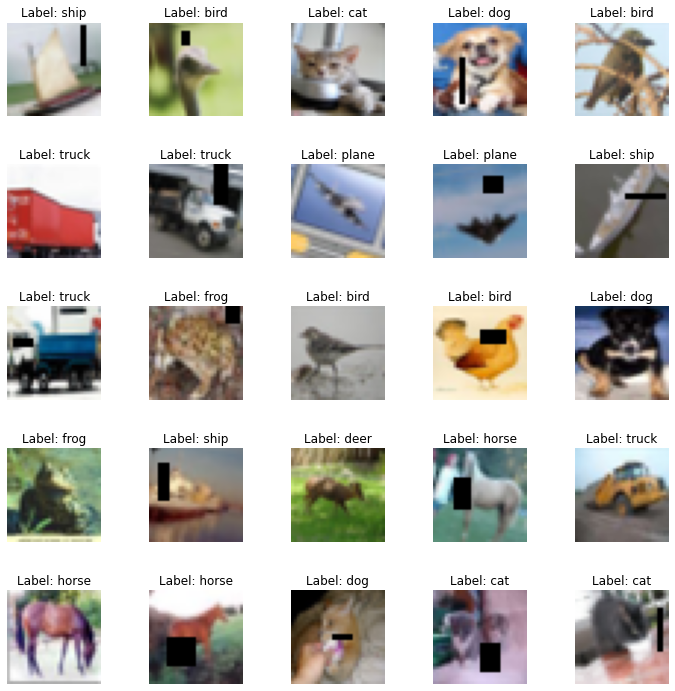

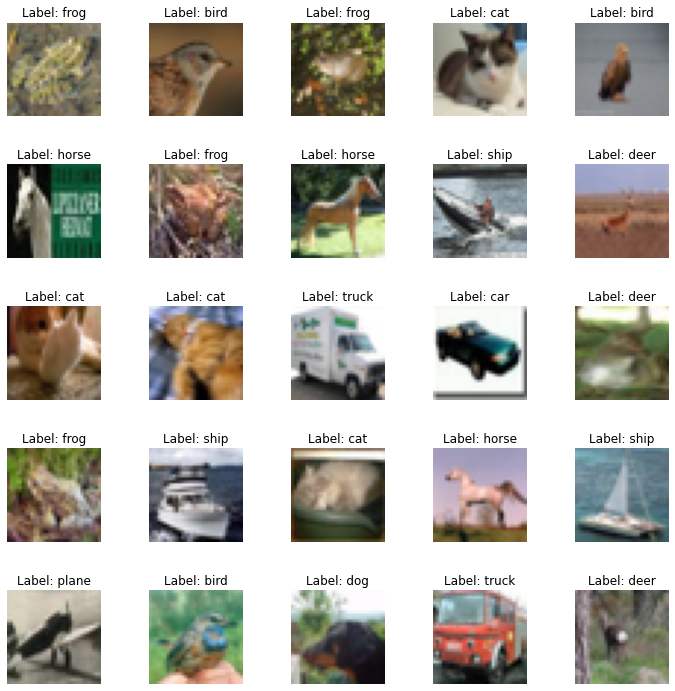

In [5]:
train_loader,test_loader,classes=getDataSet()
print("Trainging Images")
pt.plotSampleImages(train_loader,classes)
print("Testing Images")
pt.plotSampleImages(test_loader,classes)

## Get the model

In [6]:
## get the model
model = md.Net(cf.Args.dropout,"BN").to(device)  # Create model
summary(model, (3,32,32))  # Display model summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 30, 30]          36,928
              ReLU-6           [-1, 64, 30, 30]               0
       BatchNorm2d-7           [-1, 64, 30, 30]             128
           Dropout-8           [-1, 64, 30, 30]               0
            Conv2d-9           [-1, 32, 30, 30]           2,080
           Conv2d-10           [-1, 64, 30, 30]          18,496
             ReLU-11           [-1, 64, 30, 30]               0
      BatchNorm2d-12           [-1, 64, 30, 30]             128
          Dropout-13           [-1, 64, 30, 30]               0
           Conv2d-14           [-1, 64,

## training & evaluation

In [7]:
losses = []
accuracies = []
incorrect_samples = []

criterion = utils.cross_entropy_loss()  # Create loss function
optimizer = utils.sgd_optimizer(model, cf.Args.learning_rate, cf.Args.momentum)  # Create optimizer

for epoch in range(1, 100):
    print(f'Epoch {epoch}:')
    utils.train(model, train_loader, device, optimizer, criterion)
    utils.eval(model, test_loader, device, criterion, losses, accuracies, incorrect_samples)

Epoch 1:


Loss=1.13 Batch_ID=1562 Accuracy=39.75: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:07<00:00, 23.29it/s]



Test set: Average loss: 0.0429, Test Accuracy: 4975/10000 (49.75%)

Epoch 2:


Loss=0.96 Batch_ID=1562 Accuracy=53.14: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:09<00:00, 22.56it/s]



Test set: Average loss: 0.0333, Test Accuracy: 6212/10000 (62.12%)

Epoch 3:


Loss=0.90 Batch_ID=1562 Accuracy=59.39: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:11<00:00, 21.99it/s]



Test set: Average loss: 0.0295, Test Accuracy: 6631/10000 (66.31%)

Epoch 4:


Loss=0.88 Batch_ID=1562 Accuracy=62.92: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:11<00:00, 21.77it/s]



Test set: Average loss: 0.0273, Test Accuracy: 6845/10000 (68.45%)

Epoch 5:


Loss=0.61 Batch_ID=1562 Accuracy=65.75: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.66it/s]



Test set: Average loss: 0.0260, Test Accuracy: 7012/10000 (70.12%)

Epoch 6:


Loss=0.91 Batch_ID=1562 Accuracy=67.60: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.60it/s]



Test set: Average loss: 0.0241, Test Accuracy: 7309/10000 (73.09%)

Epoch 7:


Loss=0.88 Batch_ID=1562 Accuracy=69.81: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.59it/s]



Test set: Average loss: 0.0227, Test Accuracy: 7492/10000 (74.92%)

Epoch 8:


Loss=1.19 Batch_ID=1562 Accuracy=71.18: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.54it/s]



Test set: Average loss: 0.0212, Test Accuracy: 7661/10000 (76.61%)

Epoch 9:


Loss=0.59 Batch_ID=1562 Accuracy=72.26: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.64it/s]



Test set: Average loss: 0.0202, Test Accuracy: 7799/10000 (77.99%)

Epoch 10:


Loss=0.75 Batch_ID=1562 Accuracy=73.58: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.54it/s]



Test set: Average loss: 0.0198, Test Accuracy: 7818/10000 (78.18%)

Epoch 11:


Loss=0.75 Batch_ID=1562 Accuracy=74.38: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.53it/s]



Test set: Average loss: 0.0190, Test Accuracy: 7883/10000 (78.83%)

Epoch 12:


Loss=0.80 Batch_ID=1562 Accuracy=75.35: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.57it/s]



Test set: Average loss: 0.0197, Test Accuracy: 7846/10000 (78.46%)

Epoch 13:


Loss=0.59 Batch_ID=1562 Accuracy=75.61: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.51it/s]



Test set: Average loss: 0.0182, Test Accuracy: 8003/10000 (80.03%)

Epoch 14:


Loss=1.15 Batch_ID=1562 Accuracy=76.17: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.57it/s]



Test set: Average loss: 0.0177, Test Accuracy: 8095/10000 (80.95%)

Epoch 15:


Loss=1.31 Batch_ID=1562 Accuracy=76.65: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.48it/s]



Test set: Average loss: 0.0178, Test Accuracy: 8114/10000 (81.14%)

Epoch 16:


Loss=1.30 Batch_ID=1562 Accuracy=77.48: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.50it/s]



Test set: Average loss: 0.0174, Test Accuracy: 8138/10000 (81.38%)

Epoch 17:


Loss=0.60 Batch_ID=1562 Accuracy=77.90: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.50it/s]



Test set: Average loss: 0.0166, Test Accuracy: 8219/10000 (82.19%)

Epoch 18:


Loss=0.82 Batch_ID=1562 Accuracy=78.04: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.46it/s]



Test set: Average loss: 0.0168, Test Accuracy: 8211/10000 (82.11%)

Epoch 19:


Loss=0.28 Batch_ID=1562 Accuracy=78.50: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.60it/s]



Test set: Average loss: 0.0166, Test Accuracy: 8214/10000 (82.14%)

Epoch 20:


Loss=0.57 Batch_ID=1562 Accuracy=79.02: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.52it/s]



Test set: Average loss: 0.0157, Test Accuracy: 8310/10000 (83.10%)

Epoch 21:


Loss=0.43 Batch_ID=1562 Accuracy=78.97: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.49it/s]



Test set: Average loss: 0.0168, Test Accuracy: 8149/10000 (81.49%)

Epoch 22:


Loss=0.74 Batch_ID=1562 Accuracy=79.40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.47it/s]



Test set: Average loss: 0.0153, Test Accuracy: 8326/10000 (83.26%)

Epoch 23:


Loss=0.69 Batch_ID=1562 Accuracy=79.89: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.51it/s]



Test set: Average loss: 0.0155, Test Accuracy: 8358/10000 (83.58%)

Epoch 24:


Loss=0.83 Batch_ID=1562 Accuracy=79.98: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.46it/s]



Test set: Average loss: 0.0150, Test Accuracy: 8383/10000 (83.83%)

Epoch 25:


Loss=0.40 Batch_ID=1562 Accuracy=80.33: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.59it/s]



Test set: Average loss: 0.0149, Test Accuracy: 8399/10000 (83.99%)

Epoch 26:


Loss=0.60 Batch_ID=1562 Accuracy=80.52: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.50it/s]



Test set: Average loss: 0.0150, Test Accuracy: 8353/10000 (83.53%)

Epoch 27:


Loss=0.52 Batch_ID=1562 Accuracy=80.59: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.51it/s]



Test set: Average loss: 0.0148, Test Accuracy: 8414/10000 (84.14%)

Epoch 28:


Loss=0.30 Batch_ID=1562 Accuracy=80.91: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.55it/s]



Test set: Average loss: 0.0146, Test Accuracy: 8447/10000 (84.47%)

Epoch 29:


Loss=0.43 Batch_ID=1562 Accuracy=81.21: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.49it/s]



Test set: Average loss: 0.0144, Test Accuracy: 8485/10000 (84.85%)

Epoch 30:


Loss=0.45 Batch_ID=1562 Accuracy=81.44: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.48it/s]



Test set: Average loss: 0.0147, Test Accuracy: 8461/10000 (84.61%)

Epoch 31:


Loss=0.47 Batch_ID=1562 Accuracy=81.44: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.51it/s]



Test set: Average loss: 0.0141, Test Accuracy: 8498/10000 (84.98%)

Epoch 32:


Loss=0.50 Batch_ID=1562 Accuracy=81.90: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.54it/s]



Test set: Average loss: 0.0140, Test Accuracy: 8484/10000 (84.84%)

Epoch 33:


Loss=0.14 Batch_ID=1562 Accuracy=82.09: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.51it/s]



Test set: Average loss: 0.0148, Test Accuracy: 8421/10000 (84.21%)

Epoch 34:


Loss=0.26 Batch_ID=1562 Accuracy=82.16: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.52it/s]



Test set: Average loss: 0.0139, Test Accuracy: 8516/10000 (85.16%)

Epoch 35:


Loss=0.14 Batch_ID=1562 Accuracy=82.33: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.47it/s]



Test set: Average loss: 0.0143, Test Accuracy: 8497/10000 (84.97%)

Epoch 36:


Loss=0.67 Batch_ID=1562 Accuracy=82.70: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:13<00:00, 21.39it/s]



Test set: Average loss: 0.0135, Test Accuracy: 8546/10000 (85.46%)

Epoch 37:


Loss=0.28 Batch_ID=1562 Accuracy=82.34: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.55it/s]



Test set: Average loss: 0.0134, Test Accuracy: 8614/10000 (86.14%)

Epoch 38:


Loss=0.55 Batch_ID=1562 Accuracy=82.86: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:13<00:00, 21.37it/s]



Test set: Average loss: 0.0138, Test Accuracy: 8557/10000 (85.57%)

Epoch 39:


Loss=0.80 Batch_ID=1562 Accuracy=82.91: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.48it/s]



Test set: Average loss: 0.0133, Test Accuracy: 8584/10000 (85.84%)

Epoch 40:


Loss=0.57 Batch_ID=1562 Accuracy=82.90: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.50it/s]



Test set: Average loss: 0.0133, Test Accuracy: 8601/10000 (86.01%)

Epoch 41:


Loss=0.68 Batch_ID=1562 Accuracy=83.09: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.42it/s]



Test set: Average loss: 0.0133, Test Accuracy: 8594/10000 (85.94%)

Epoch 42:


Loss=0.62 Batch_ID=1562 Accuracy=83.26: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.52it/s]



Test set: Average loss: 0.0131, Test Accuracy: 8600/10000 (86.00%)

Epoch 43:


Loss=0.51 Batch_ID=1562 Accuracy=83.51: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.45it/s]



Test set: Average loss: 0.0134, Test Accuracy: 8581/10000 (85.81%)

Epoch 44:


Loss=0.67 Batch_ID=1562 Accuracy=83.49: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.63it/s]



Test set: Average loss: 0.0131, Test Accuracy: 8594/10000 (85.94%)

Epoch 45:


Loss=0.55 Batch_ID=1562 Accuracy=83.60: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.47it/s]



Test set: Average loss: 0.0129, Test Accuracy: 8616/10000 (86.16%)

Epoch 46:


Loss=0.46 Batch_ID=1562 Accuracy=83.87: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.50it/s]



Test set: Average loss: 0.0134, Test Accuracy: 8606/10000 (86.06%)

Epoch 47:


Loss=0.42 Batch_ID=1562 Accuracy=83.93: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.53it/s]



Test set: Average loss: 0.0130, Test Accuracy: 8614/10000 (86.14%)

Epoch 49:


Loss=0.74 Batch_ID=1562 Accuracy=83.99: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.54it/s]



Test set: Average loss: 0.0128, Test Accuracy: 8662/10000 (86.62%)

Epoch 50:


Loss=0.38 Batch_ID=361 Accuracy=84.35:  23%|████████████████████████████▍                                                                                              | 361/1563 [00:16<00:56, 21.38it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.96 Batch_ID=1562 Accuracy=84.45: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.56it/s]



Test set: Average loss: 0.0127, Test Accuracy: 8648/10000 (86.48%)

Epoch 56:


Loss=0.24 Batch_ID=1562 Accuracy=84.66: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.45it/s]



Test set: Average loss: 0.0124, Test Accuracy: 8693/10000 (86.93%)

Epoch 57:


Loss=0.46 Batch_ID=491 Accuracy=85.13:  31%|██████████████████████████████████████▌                                                                                    | 490/1563 [00:22<00:49, 21.55it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.65 Batch_ID=1562 Accuracy=85.40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.61it/s]



Test set: Average loss: 0.0122, Test Accuracy: 8712/10000 (87.12%)

Epoch 63:


Loss=0.52 Batch_ID=1291 Accuracy=84.96:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1291/1563 [01:00<00:12, 21.49it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.48 Batch_ID=1562 Accuracy=85.66: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.48it/s]



Test set: Average loss: 0.0121, Test Accuracy: 8738/10000 (87.38%)

Epoch 70:


Loss=0.27 Batch_ID=1131 Accuracy=85.64:  72%|███████████████████████████████████████████████████████████████████████████████████████▍                                 | 1129/1563 [00:52<00:20, 21.57it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.22 Batch_ID=1562 Accuracy=86.16: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.51it/s]



Test set: Average loss: 0.0118, Test Accuracy: 8778/10000 (87.78%)

Epoch 77:


Loss=0.25 Batch_ID=1353 Accuracy=86.20:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1351/1563 [01:02<00:09, 21.60it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.44 Batch_ID=1562 Accuracy=86.38: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:13<00:00, 21.39it/s]



Test set: Average loss: 0.0121, Test Accuracy: 8765/10000 (87.65%)

Epoch 84:


Loss=0.14 Batch_ID=1376 Accuracy=86.22:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1375/1563 [01:03<00:08, 21.56it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.89 Batch_ID=1562 Accuracy=86.33: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.43it/s]



Test set: Average loss: 0.0115, Test Accuracy: 8800/10000 (88.00%)

Epoch 90:


Loss=0.15 Batch_ID=1562 Accuracy=86.75: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.41it/s]



Test set: Average loss: 0.0116, Test Accuracy: 8797/10000 (87.97%)

Epoch 91:


Loss=0.43 Batch_ID=149 Accuracy=86.81:   9%|███████████▋                                                                                                               | 148/1563 [00:07<01:06, 21.36it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=1.15 Batch_ID=1562 Accuracy=86.72: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.47it/s]



Test set: Average loss: 0.0113, Test Accuracy: 8802/10000 (88.02%)

Epoch 97:


Loss=0.44 Batch_ID=1562 Accuracy=87.01: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [01:12<00:00, 21.43it/s]



Test set: Average loss: 0.0117, Test Accuracy: 8810/10000 (88.10%)

Epoch 98:


Loss=0.92 Batch_ID=27 Accuracy=86.27:   2%|█▉                                                                                                                           | 25/1563 [00:01<01:10, 21.72it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Draw the curves

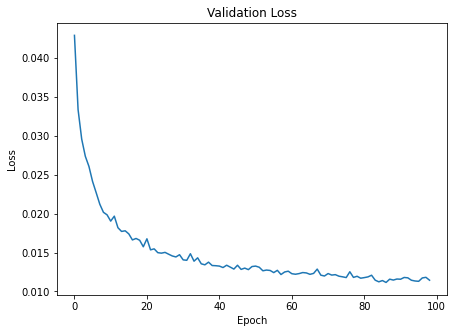

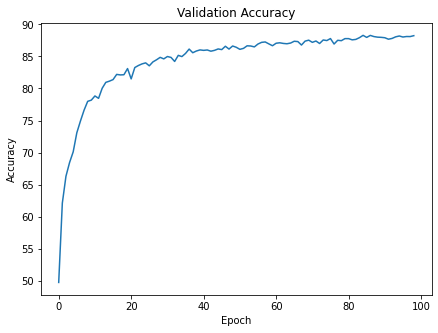

In [8]:
pt.plot_metric(losses, 'Loss')
pt.plot_metric(accuracies, 'Accuracy')

## Check the misclassifications

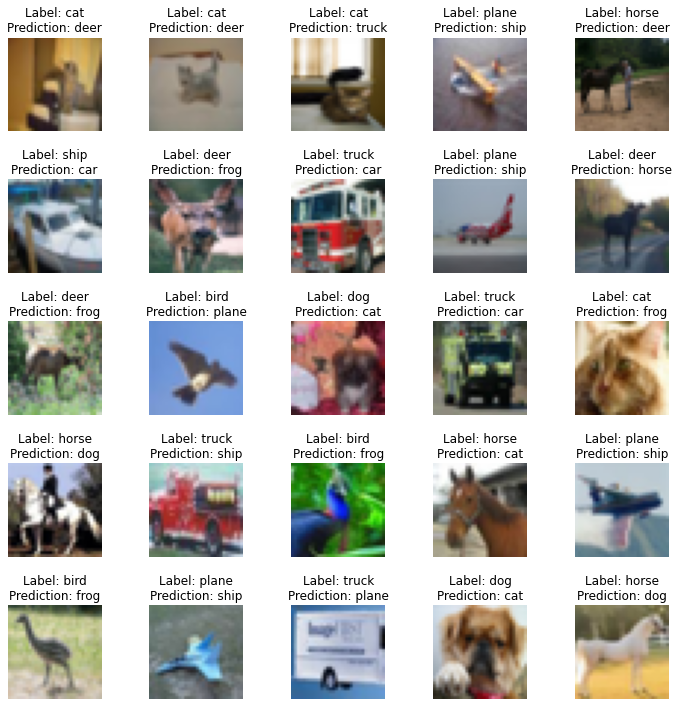

In [9]:
pt.save_and_show_result(incorrect_samples, classes)

## Summary of the class level accuracy

In [10]:
pt.class_level_accuracy(model, test_loader, device, classes)

Accuracy of plane : 89 %
Accuracy of   car : 96 %
Accuracy of  bird : 82 %
Accuracy of   cat : 72 %
Accuracy of  deer : 88 %
Accuracy of   dog : 81 %
Accuracy of  frog : 90 %
Accuracy of horse : 93 %
Accuracy of  ship : 94 %
Accuracy of truck : 92 %
